In [1]:
import sys, json, os, ast
import copy
import numpy as np
import pandas as pd
from smart_open import open
from tqdm import tqdm
import pickle as pkl
import lightgbm as lgb

sys.path.insert(1, "../..")
from src.logger import make_logger
from src.dataloader import TabularDataloader
from src.Trainer import LGBMTrainer, TFTrainer
from src.preprocess import Preprocess

from rdsutils.feature_selection import mrmr
from rdsutils.woe import WOE_Transform
from _utils.feature_selection import feature_selection as fs
from _utils.performance_eval import performance_eval_v3 as p_eval
from rdsutils.feature_selection import FeatureSelector

# new modules
from _utils.sample_weights import get_sample_weight

%load_ext autoreload
%autoreload 2

### Load Data and Preprocess

In [2]:
target = 'target_v2'
target_indeterminate = 'indeterminate_v2'
weight = "weight"
seed = 42

model_params_path = "./artifacts/models/model_params.json"
model_dir = "./artifacts/models"

# load some feature sets
with open("config.json", "r") as f:
    config = json.load(f)
    
with open("./artifacts/models/model_params.json", "r") as f:
    model_params = json.load(f)

with open(model_params_path, "r") as f:
    model_params = json.load(f)

# expn data dict
exp_dict = pd.read_csv(config["meta"]["exp_dict_path"])

# fsel classes
rankings = pd.read_csv("./artifacts/dev2_fsel_v2/ranking.csv", index_col=0)
rankings["mean"] = rankings.mean(axis=1)
rankings.sort_values("mean", inplace=True)
    
benchmark_fts = model_params["dev2_v2_benchmark"]["features"]
gen3_features = config["data_columns"]["gen3_features"]
fsel_top_100 = rankings.head(100).index.tolist()

In [3]:
# meta data columns
benchmarks = ["gen3_score", "applicant_fico_score"]
meta_cols = [target, target_indeterminate, "ri_source",
                      "weight_ri_v2", "weight_cob"]
features = list(set(gen3_features +
                    benchmark_fts + 
                    fsel_top_100))
cols = benchmarks + meta_cols + features

train_df = pd.read_parquet(config["data"]["clean"]["all_features_dev2"], columns=cols)
test_df = pd.read_parquet(config["data"]["clean"]["all_features_oot2"], columns=cols)

In [4]:
%%time
from src.preprocess import Preprocess

col = "ri_source"
weights = {"booked": 1,
           "proxy": 1,
           "others": 0.25}

pp = Preprocess(exp_dict)

train_df["weight_eval"] = train_df["weight_cob"] * train_df["weight_ri_v2"]
test_df["weight_eval"] = test_df["weight_cob"] * test_df["weight_ri_v2"]

train_df = pp.transform(train_df, features, weights, 
                        drop_indeterminate=target_indeterminate, 
                        existing_weights_col="weight_eval")
test_df = pp.transform(test_df, features, weights,
                       drop_indeterminate=None,
                       existing_weights_col="weight_eval")


100%|██████████| 129/129 [00:54<00:00,  2.36it/s]



        added columns:
            weight: training sample_weight scaled using provided weights by ri_source
                weight_eval * weight_sample
        
dropping indeterminate col: indeterminate_v2


100%|██████████| 129/129 [00:15<00:00,  8.51it/s]



        added columns:
            weight: training sample_weight scaled using provided weights by ri_source
                weight_eval * weight_sample
        
CPU times: user 39.1 s, sys: 34.1 s, total: 1min 13s
Wall time: 1min 12s


In [5]:
print("----- weights for model fitting -----")
display(train_df[["weight", "ri_source"]].groupby("ri_source")["weight"].sum())
display(test_df[["weight", "ri_source"]].groupby("ri_source")["weight"].sum())

print("----- weights for evaluations -----")
display(train_df[["weight_eval", "ri_source"]].groupby("ri_source")["weight_eval"].sum())
display(test_df[["weight_eval", "ri_source"]].groupby("ri_source")["weight_eval"].sum())

----- weights for model fitting -----


ri_source
booked    105902.000
others    202376.125
proxy     194687.000
Name: weight, dtype: float64

ri_source
booked    30041.5
others    54878.0
proxy     57784.5
Name: weight, dtype: float64

----- weights for evaluations -----


ri_source
booked    105902.0
others    809504.5
proxy     194687.0
Name: weight_eval, dtype: float64

ri_source
booked     30041.5
others    219512.0
proxy      57784.5
Name: weight_eval, dtype: float64

### Train Models

In [6]:
for mname in tqdm(model_params):
    if "dev2_v2" in mname:
        params_ = model_params[mname]["params"]
        fts_ = model_params[mname]["features"]
        mtype = model_params[mname]["model_type"]

        lgbm_ = lgb.LGBMClassifier(**params_)
        trainer = LGBMTrainer()
        trainer.train(lgbm_, 
                      train_df,
                      features = fts_,
                      target_col = target,
                      sample_weight = train_df[weight]
                     )
        trainer.save_model(os.path.join(model_dir, f"{mtype}-{mname}.pkl"))

  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


100%|██████████| 8/8 [00:51<00:00,  6.41s/it]


### Model Eval

In [7]:
models = os.listdir(model_dir)
dev2_models = filter(lambda mname: "dev2_v2" in mname, models)
pred_cols = []

for mname in tqdm(dev2_models):
    mpath = os.path.join(model_dir, mname)
    with open(mpath, "rb") as f:
        model = pkl.load(f)
    
    pred_col = mname.split(".")[0]
    pred_col = pred_col.split("-")[1] # remove lightgbm- and .pkl
    test_df[f"pred_{pred_col}"] = model.predict_proba(test_df[model.feature_name_])[:,1]
    pred_cols.append(f"pred_{pred_col}")

2it [00:02,  1.34s/it]


In [8]:
test_df["pred_gen3"] = -test_df["gen3_score"]  # reverse dir of gen3 score
test_df["pred_fico"] = -test_df["applicant_fico_score"]

pred_cols = ["pred_gen3", "pred_fico"] + pred_cols

In [14]:
from rdsutils.metrics import get_pred_reports

perf = get_pred_reports(test_df, target, pred_cols, sample_weight_col="weight_eval").sort_values("ks")
perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
display(perf.round(4))

,auc,ap,ks,ks_chg
pred_fico,0.7380,0.3401,35.05,0.8887
pred_gen3,0.7668,0.3622,39.44,1.0000
pred_dev2_v2_benchmark_mc,0.7791,0.3810,41.22,1.0451
pred_dev2_v2_benchmark,0.7836,0.3891,42.03,1.0657


In [15]:
for t in ["booked", "proxy", "others"]:
    print(f"-------- {t} --------")
    test_df_ = test_df[test_df.ri_source==t]
    perf = get_pred_reports(test_df_, target, pred_cols, 
                            sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

-------- booked --------


,auc,ap,ks,ks_chg
pred_fico,0.5904,0.0583,13.57,0.4771
pred_gen3,0.6909,0.0966,28.44,1.0000
pred_dev2_v2_benchmark,0.7320,0.1216,34.31,1.2064
pred_dev2_v2_benchmark_mc,0.7264,0.1126,34.45,1.2113


-------- proxy --------


,auc,ap,ks,ks_chg
pred_fico,0.6351,0.1347,19.20,0.6916
pred_gen3,0.6945,0.1645,27.76,1.0000
pred_dev2_v2_benchmark_mc,0.7132,0.1741,31.04,1.1182
pred_dev2_v2_benchmark,0.7201,0.1809,32.27,1.1625


-------- others --------


,auc,ap,ks,ks_chg
pred_fico,0.7311,0.3675,34.18,0.8992
pred_gen3,0.7572,0.3890,38.01,1.0000
pred_dev2_v2_benchmark_mc,0.7697,0.4092,39.88,1.0492
pred_dev2_v2_benchmark,0.7743,0.4170,40.78,1.0729


Text(0.5, 1.0, 'Prescreen Dev2 v2 - ROC Curve')

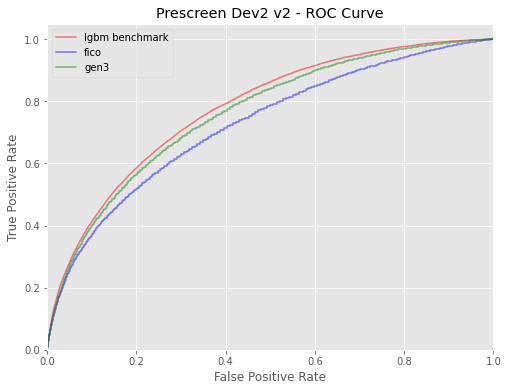

In [13]:
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult

plt.style.use("ggplot")

y_true = test_df[target]
y_scores = [(test_df["pred_dev2_v2_benchmark_mc"], "lgbm benchmark"),
            (test_df["pred_fico"], "fico"),
            (test_df["pred_gen3"], "gen3")]
sample_weight = test_df[weight]

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_auc_curve_mult(y_true, y_scores, sample_weight, colors=["r", "b", "g"], 
                    fill_area=False, alpha=0.5,
                    ax=axs)
axs.set_title("Prescreen Dev2 v2 - ROC Curve")

pred_dev2_v2_benchmark_mc AUC:  0.77909  KS:  41.1
applicant_fico_score AUC:  0.73799  KS:  35.0
gen3_score AUC:  0.76681  KS:  39.3

Gains Table--Model:
   pct_cum_acct   #accts     min     max  target_num pct_cum_target  \
0          4.5%  13895.5  0.5084  0.9711      7464.9          16.8%   
1          9.1%  14050.5  0.3931  0.5084      5735.1          29.7%   
2         13.7%  14260.0  0.3243  0.3931      4537.6          39.9%   
3         18.4%  14454.0  0.2732  0.3243      3817.0          48.5%   
4         23.2%  14671.5  0.2333  0.2732      3243.5          55.8%   
5         28.1%  14950.5  0.2004  0.2333      2955.8          62.4%   
6         33.0%  15018.0  0.1737  0.2004      2491.2          68.0%   
7         37.9%  15295.0  0.1514  0.1737      2272.3          73.1%   
8         42.9%  15350.5  0.1325  0.1514      2028.2          77.7%   
9         48.0%  15494.5  0.1161  0.1325      1795.9          81.8%   
10        53.1%  15678.0  0.1016  0.1161      1504.5          85.

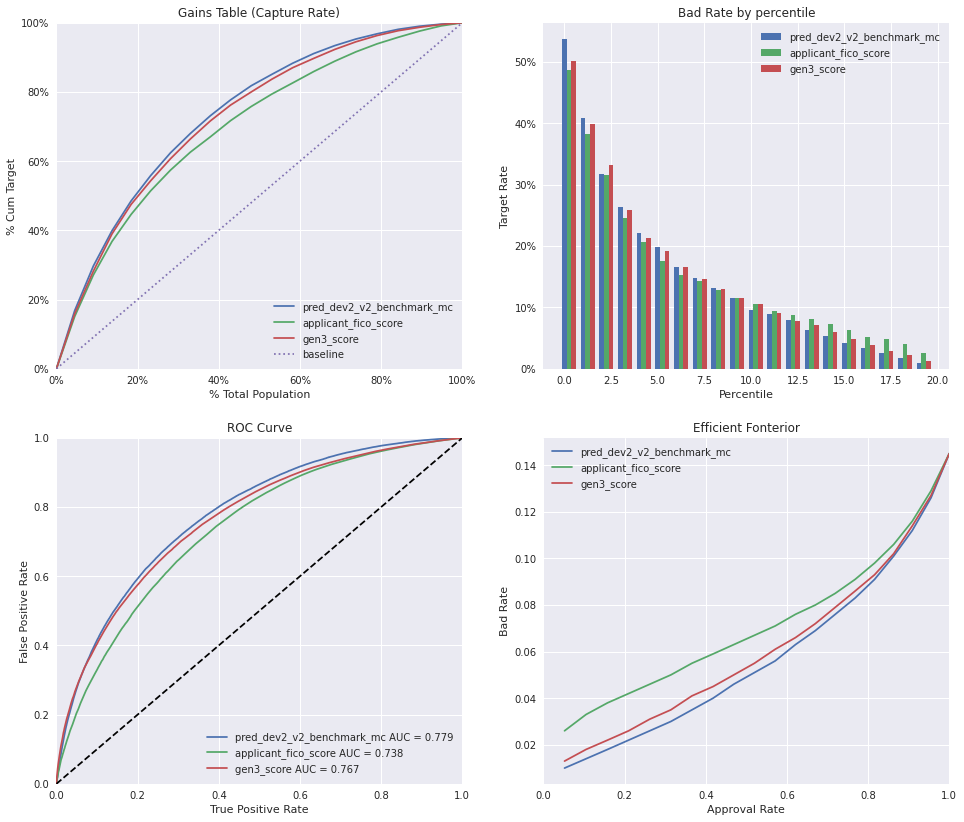

(0.7668079131067378, 39.300000000000004)

In [25]:
p_eval.model_score_eval(test_df[target],
                        test_df['pred_dev2_v2_benchmark_mc'],
                        test_df['applicant_fico_score'],
                        test_df['gen3_score'],
                        Y_weight=test_df["weight_eval"],decile=20)

In [16]:
import shap
from src.utils.governance import get_pdp, get_shap_dependence, pickle_obj
from src.utils.governance import get_feature_by_importance

def save_pdp(model, modeling_df, features, 
             features_plot_order, dir_path, suffix=""):
    
    os.makedirs(dir_path, exist_ok=True)
    fig = get_pdp(modeling_df[features], features, model,
                  features_plot_order, ncols=6)
    fig.savefig(os.path.join(dir_path, f"pdp{suffix}.png"))


def save_shap_dependence(model, modeling_df, features, dir_path, suffix=""):    
    os.makedirs(dir_path, exist_ok=True)
    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(modeling_df[model.feature_name_])
    
    pickle_obj(shap_values, os.path.join(dir_path, f"shap_values{suffix}.pkl"))
    
    fig = get_shap_dependence(modeling_df[model.feature_name_], 
                              shap_values[1], features, 
                              interaction_index=None)
    
    fig.savefig(os.path.join(dir_path, f"shap_dependence{suffix}.png"))

with open("./artifacts/models/lightgbm-dev2_v2_benchmark.pkl", "rb") as f:
    lgbm = pkl.load(f)
    
with open("./artifacts/models/lightgbm-dev2_v2_benchmark_mc.pkl", "rb") as f:
    lgbm_mc = pkl.load(f)
    
feature_by_imp = get_feature_by_importance(lgbm)
feature_by_imp_mc = get_feature_by_importance(lgbm_mc)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

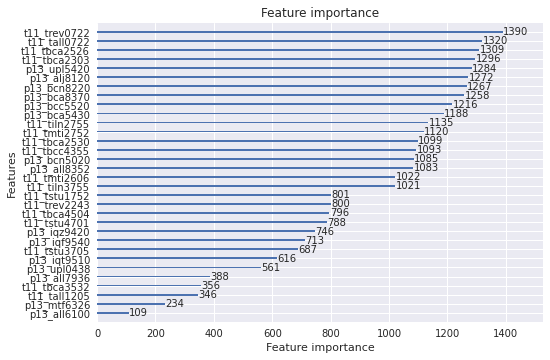

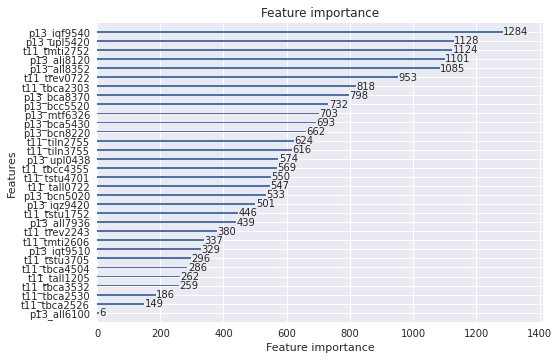

In [17]:
lgb.plot_importance(lgbm.booster_)
lgb.plot_importance(lgbm_mc.booster_)

32it [00:14,  2.25it/s]


CPU times: user 20min 30s, sys: 280 ms, total: 20min 31s
Wall time: 16.3 s


32it [00:12,  2.52it/s]


CPU times: user 19min 5s, sys: 173 ms, total: 19min 5s
Wall time: 14.8 s


CPU times: user 3min 14s, sys: 181 ms, total: 3min 14s
Wall time: 6.75 s


CPU times: user 2min 3s, sys: 129 ms, total: 2min 3s
Wall time: 4.95 s


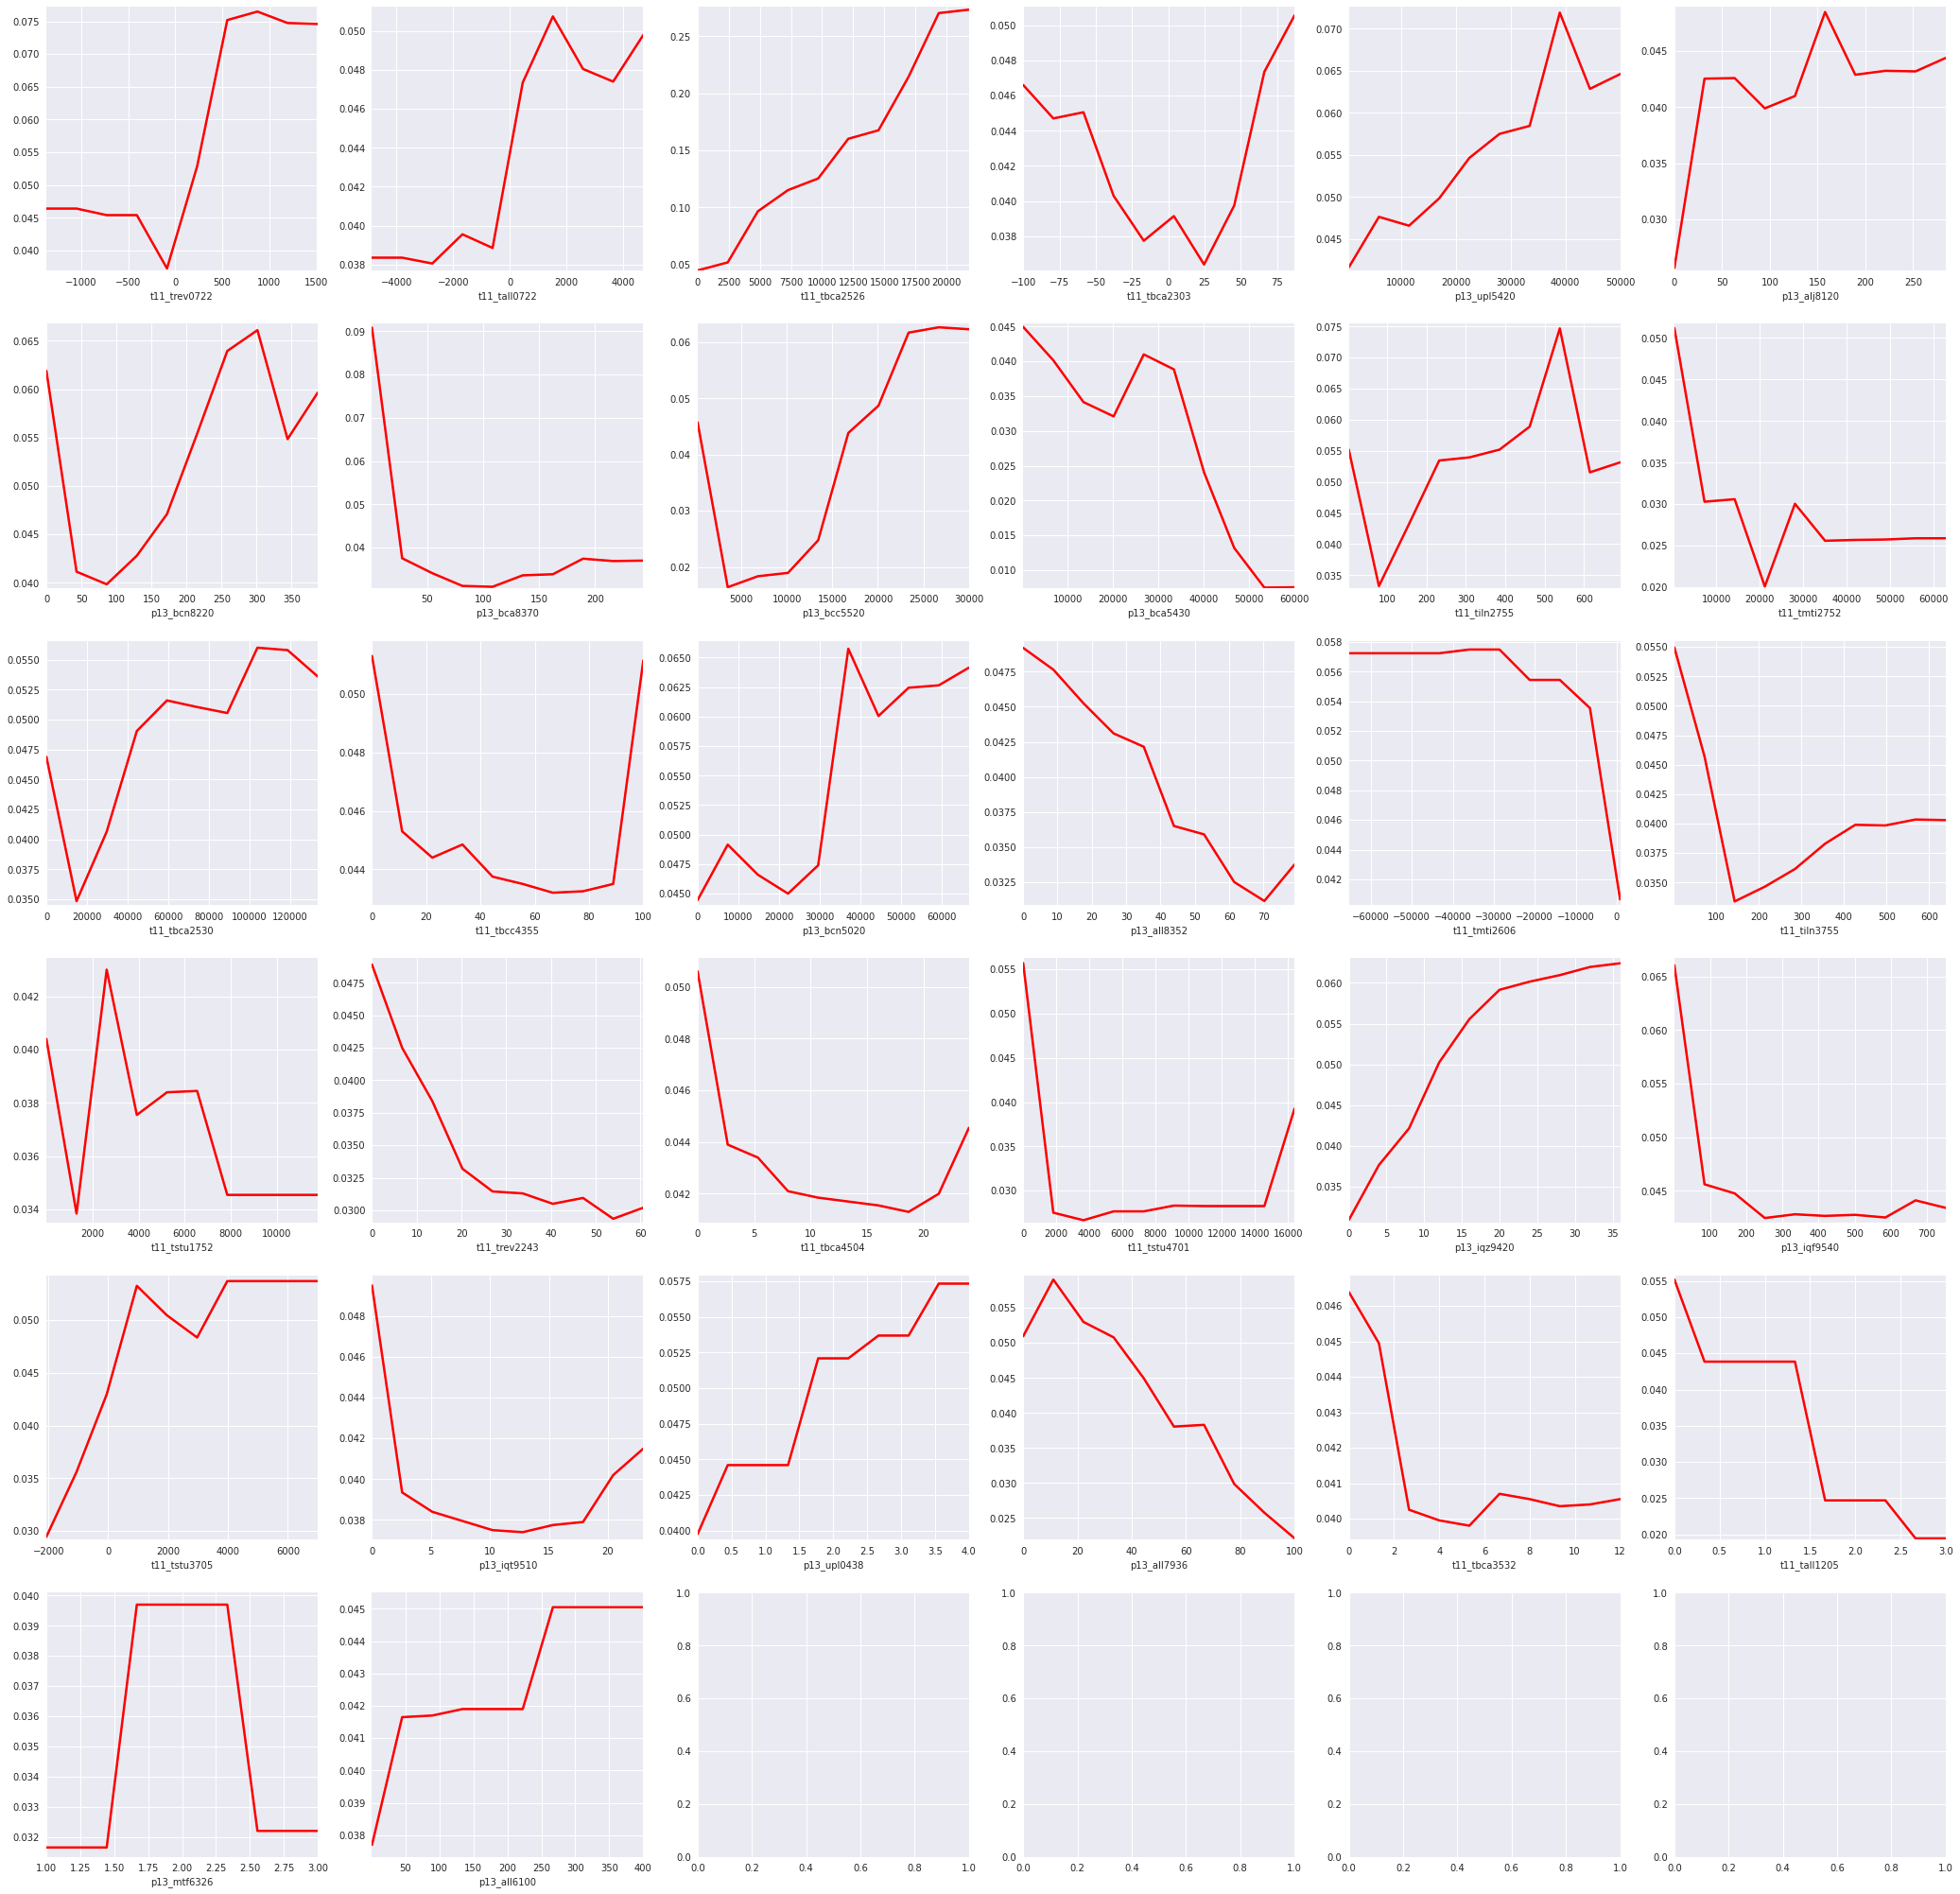

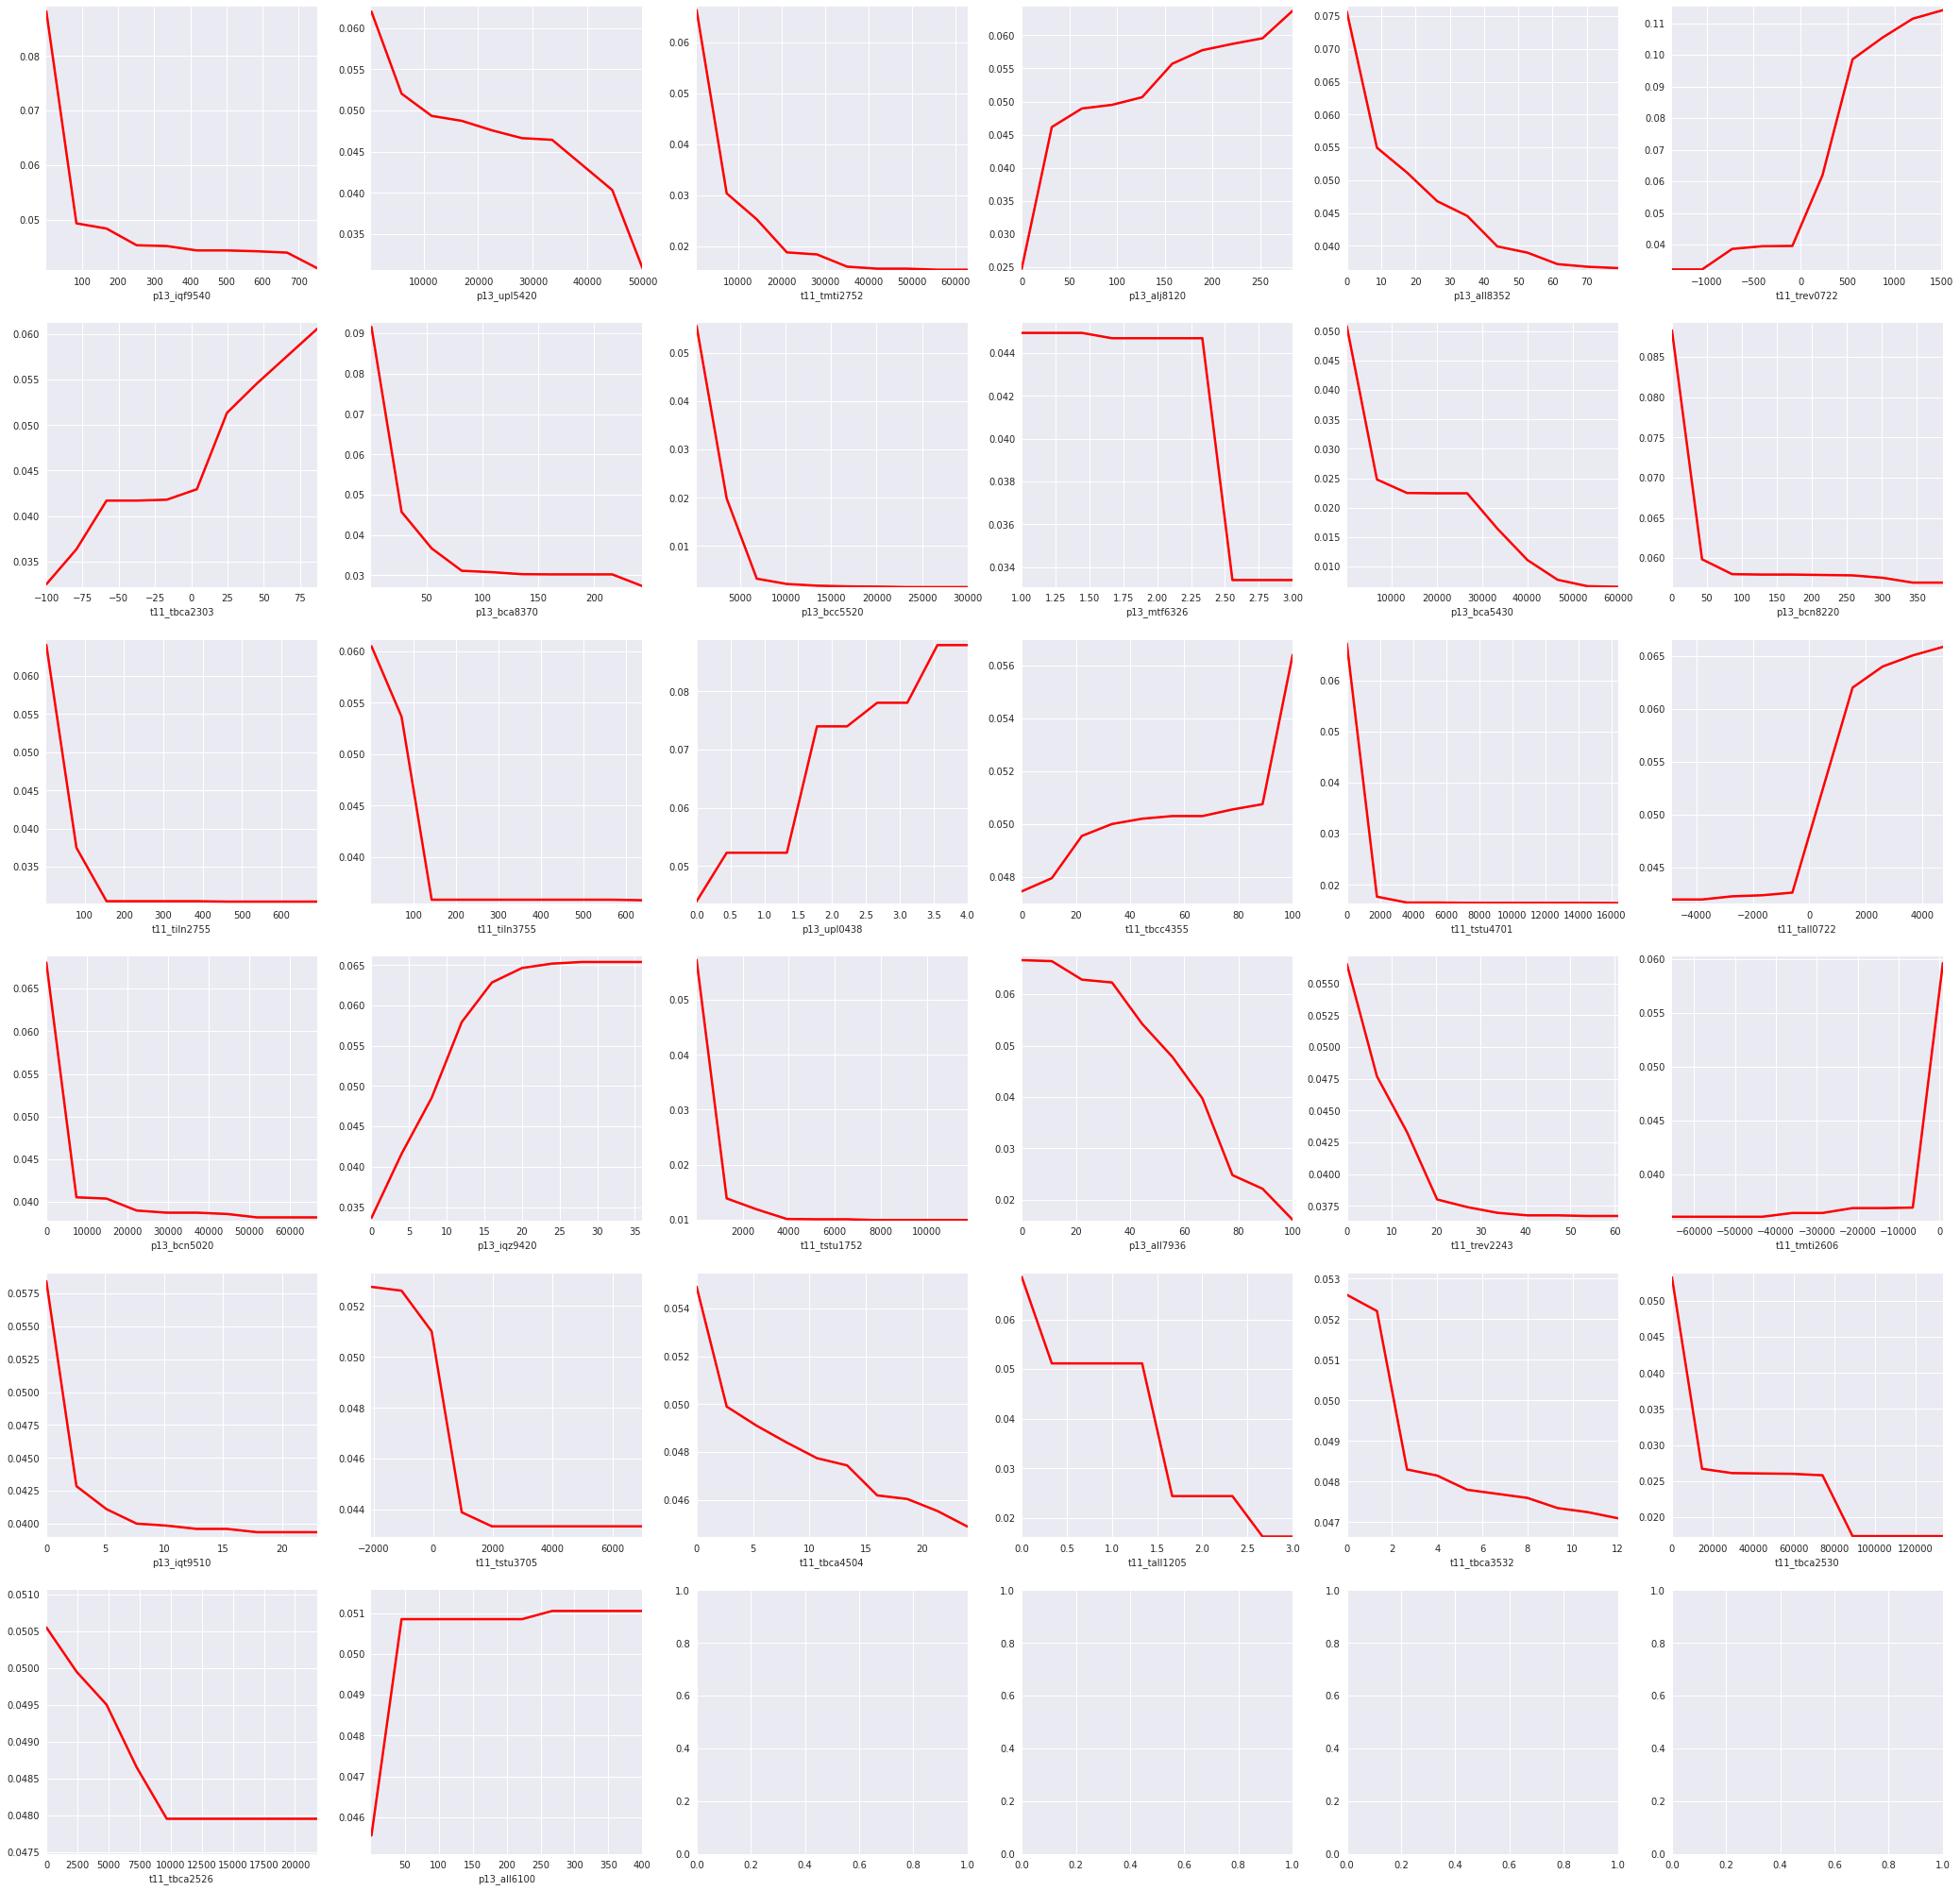

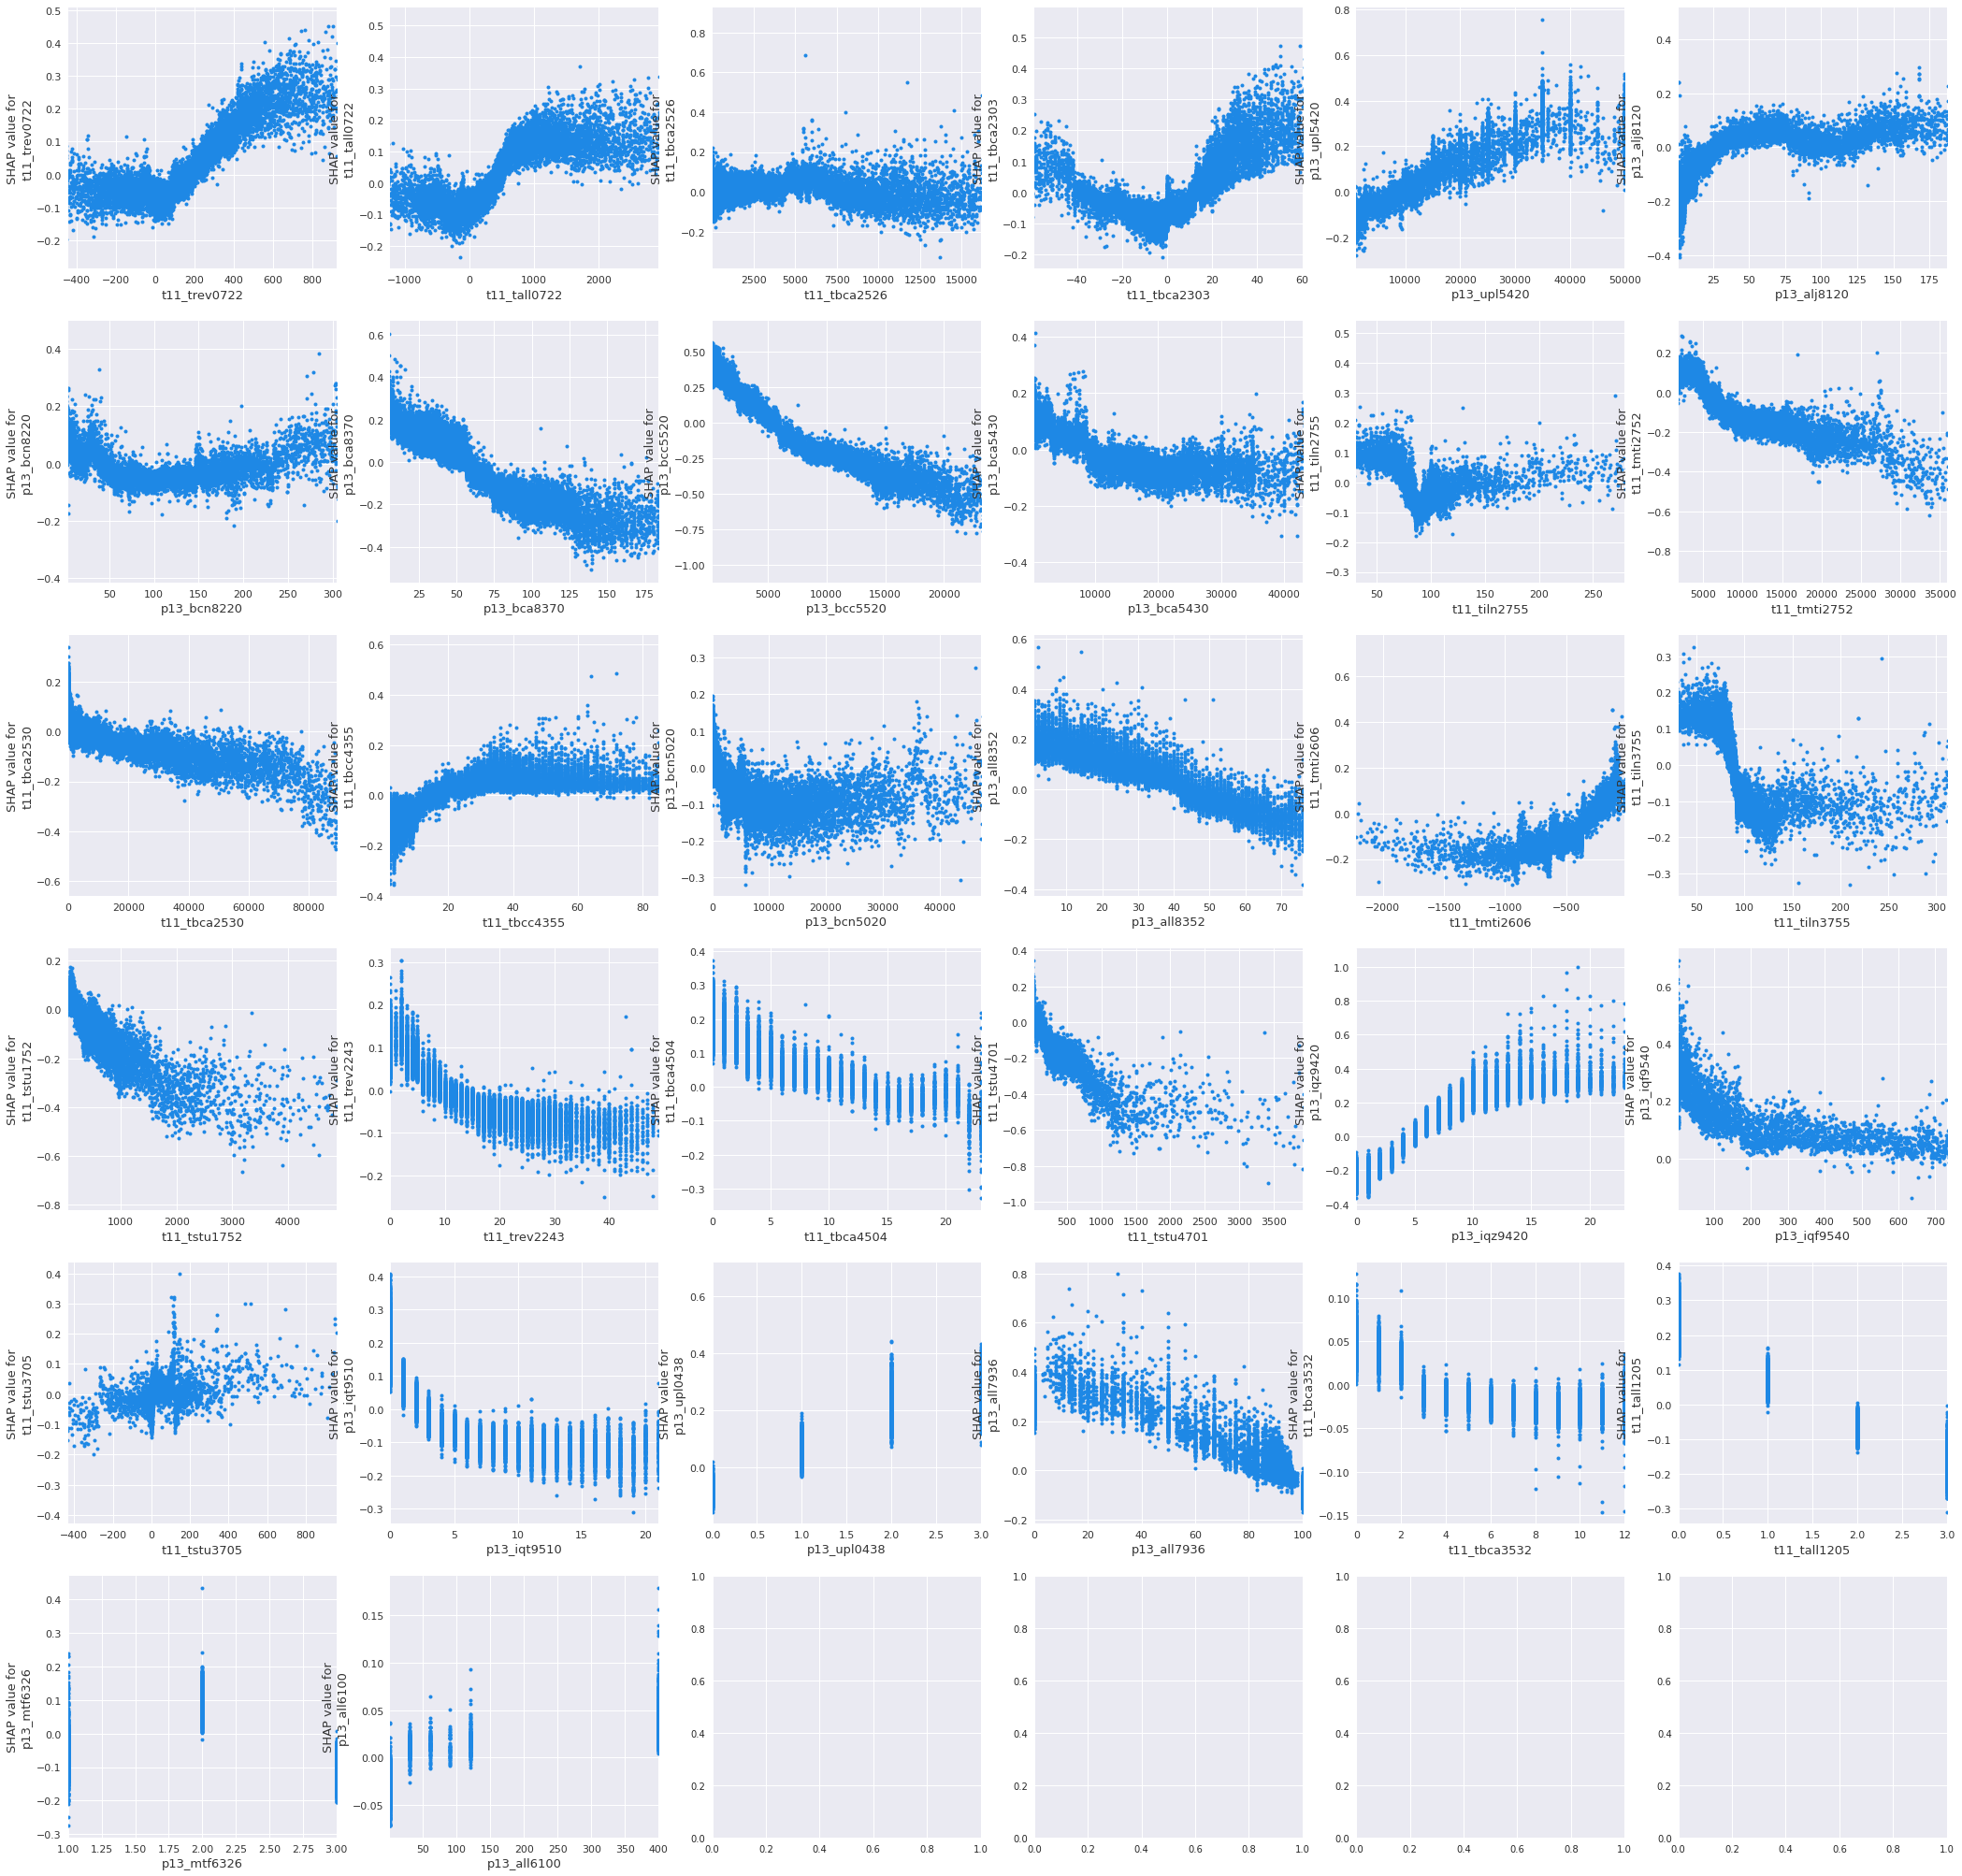

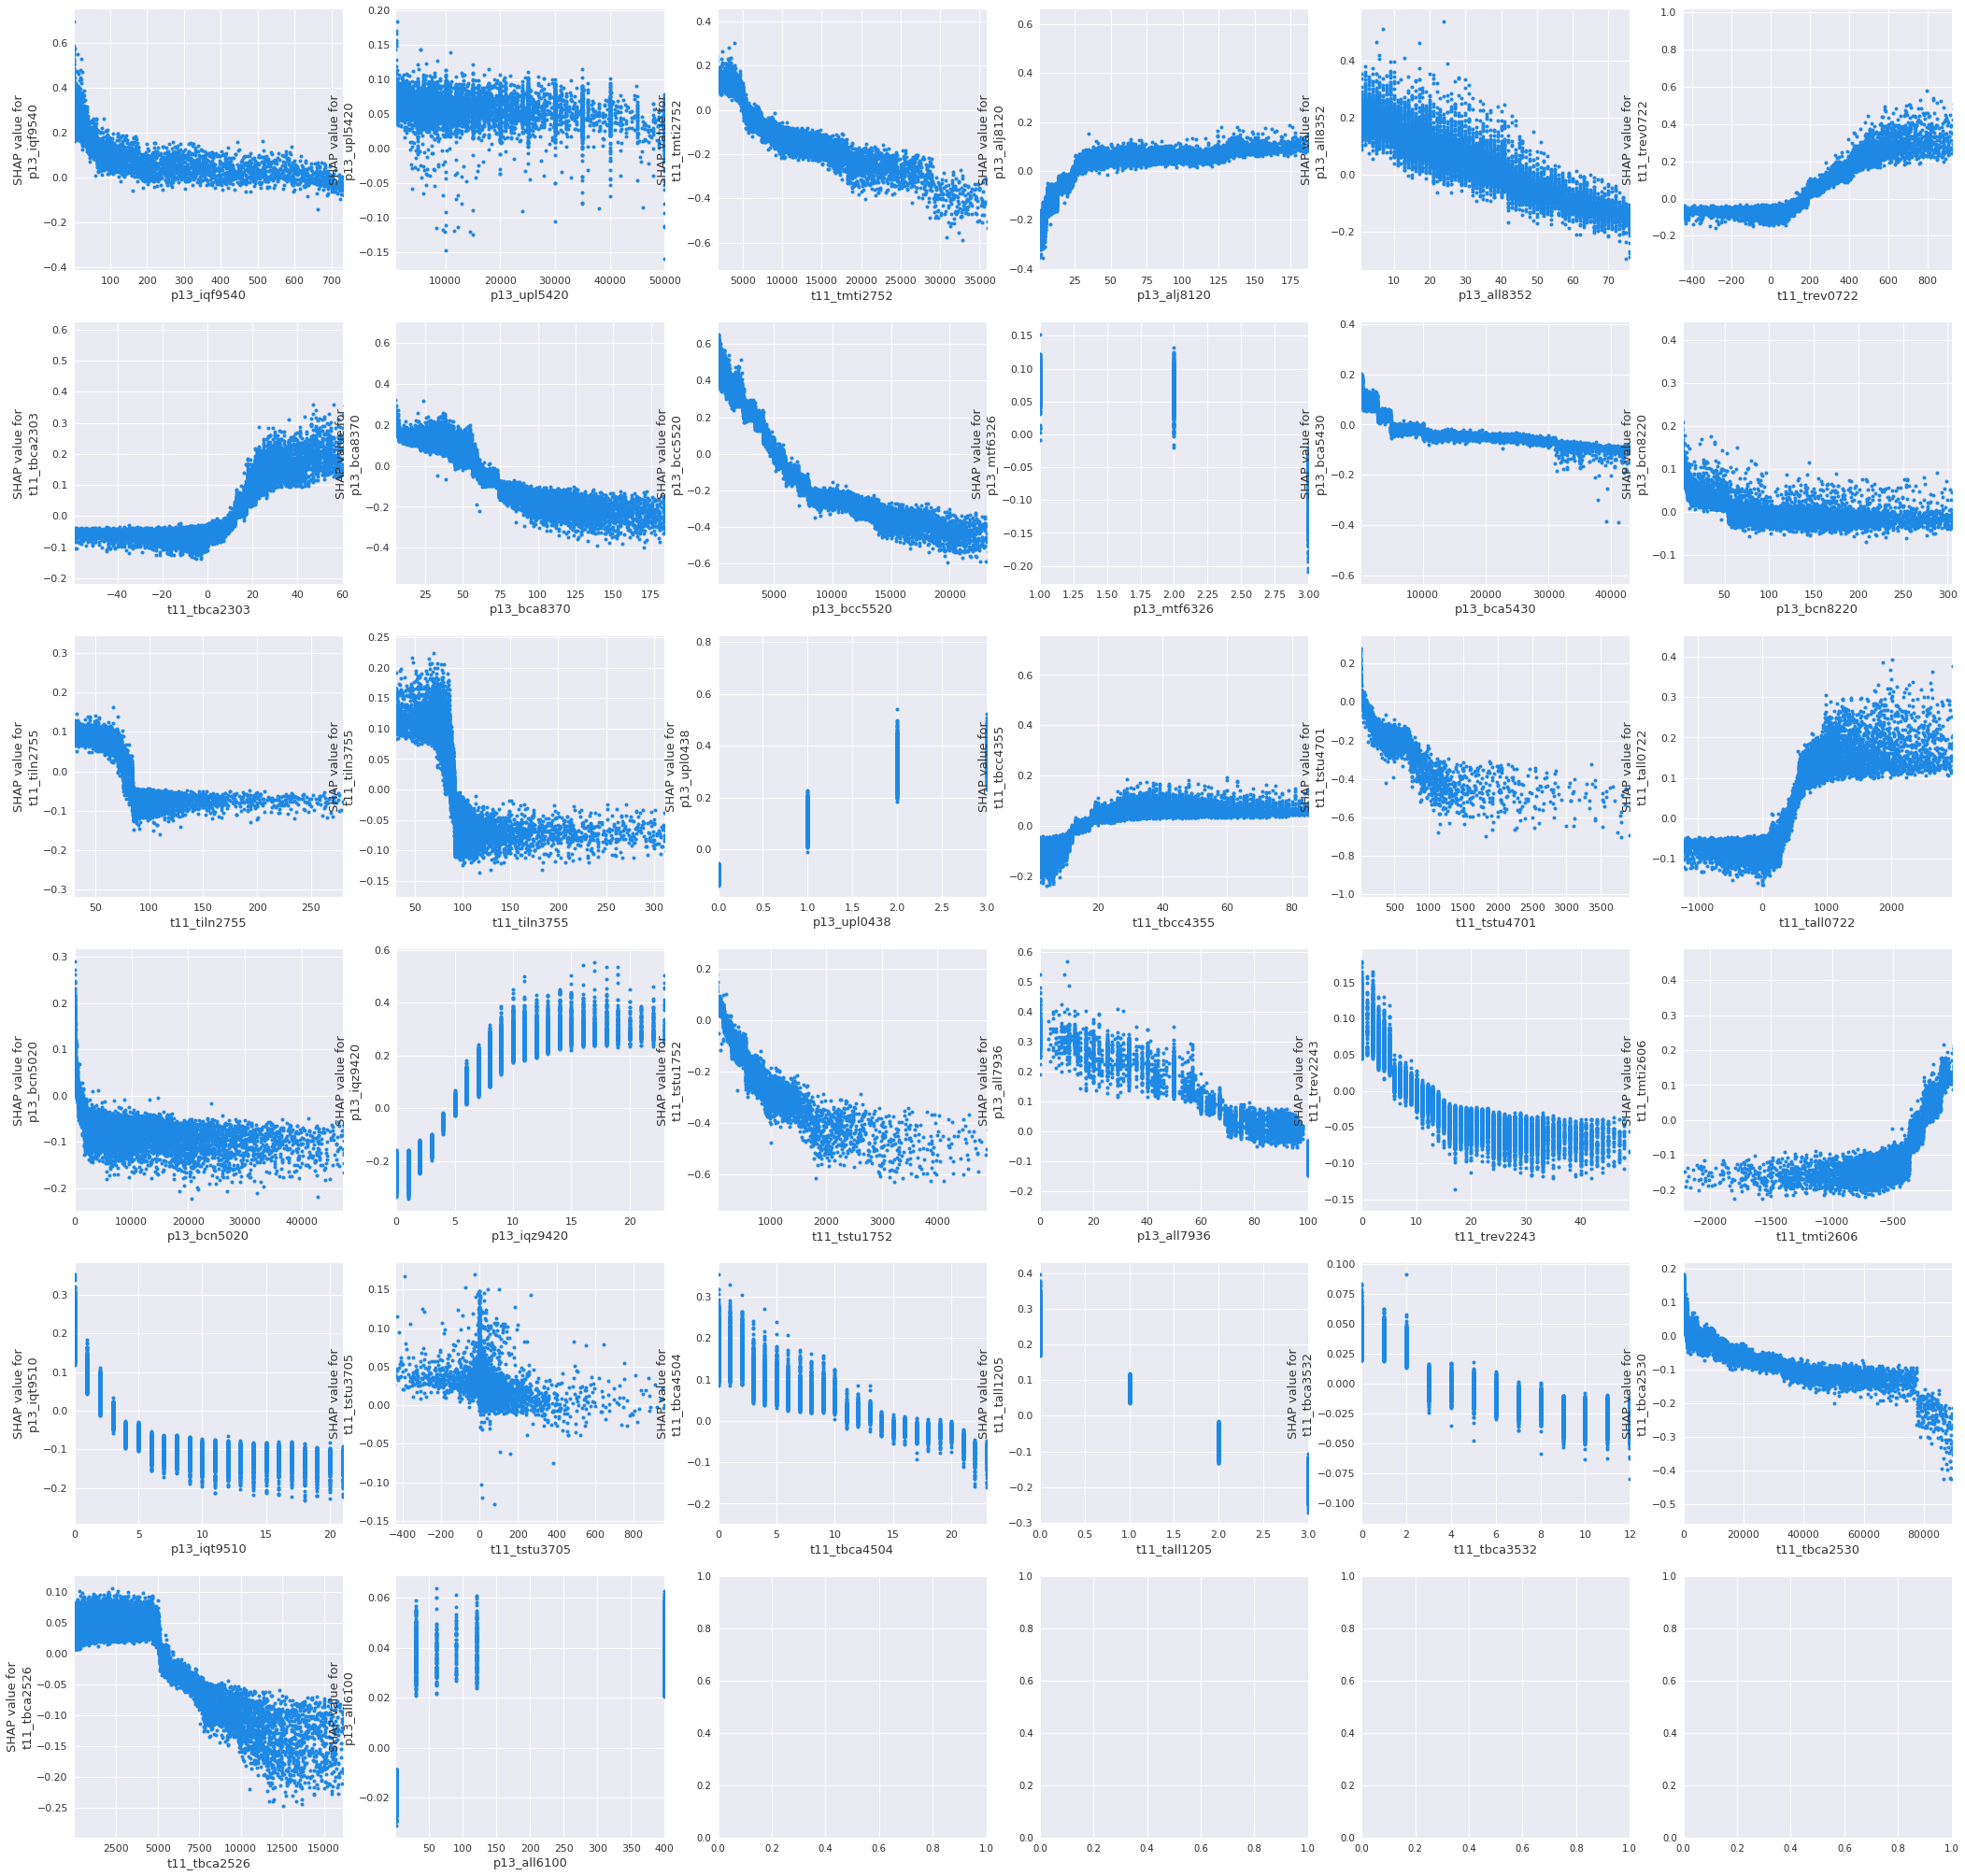

In [19]:
df_ = train_df.sample(n=20000, random_state=seed)
dir_path = "./artifacts/dev2-v2-model-artifacts"

%time save_pdp(lgbm, df_, lgbm.feature_name_, feature_by_imp, dir_path, suffix="")
%time save_pdp(lgbm_mc, df_, lgbm_mc.feature_name_, feature_by_imp_mc, dir_path, suffix="_mc")

%time save_shap_dependence(lgbm, df_, feature_by_imp, dir_path, suffix="")
%time save_shap_dependence(lgbm_mc, df_, feature_by_imp_mc, dir_path, suffix="_mc")

In [22]:
with open("./artifacts/dev2_fsel_v2/woe_dict.pkl", "rb") as f:
    woe_dict = pkl.load(f)

def get_feature_descriptions(features, data_dict):
    dd_cols = ["field_name", "description", "long description", "attr_grp", "categorical", "type"]
    dd = data_dict[dd_cols]
    dd = dd[dd.field_name.isin(lgbm_mc.feature_name_)]
    dd.set_index("field_name", inplace=True)
    return dd.loc[features]

feature_dict = get_feature_descriptions(feature_by_imp_mc, exp_dict)

dir_map = dict(zip(lgbm_mc.feature_name_, lgbm_mc.get_params()["monotone_constraints"]))
feature_dict["dir"] = [dir_map[k] for k in feature_dict.index.values]
display(feature_dict)
feature_dict.to_csv("./artifacts/dev2-v2-model-artifacts/feature_dict.csv")

,description,long description,attr_grp,categorical,type,dir
field_name,,,,,,
p13_iqf9540,IQF9540,Number of days since the most recent personal ...,Public Records/Inquiry,[9999],int,-1
p13_upl5420,UPL5420,Maximum credit amount on open unsecured person...,Balance Amount Payment,"[999999999, 999999998, 999999997, 999999996]",int,-1
t11_tmti2752,NaN,Total actual payment over the last 6 months on...,Payment magnitude,"[999999999, 999999998, 999999997, 999999996]",int,-1
p13_alj8120,ALJ8120,Number of months since the most recently opene...,Age/Recency,"[9999, 9998, 9996, 9994]",int,1
p13_all8352,ALL8352,Average number of months on trades since the m...,Age/Recency,"[9999, 9996]",int,-1
t11_trev0722,NaN,Difference between Q1 (m00-m03) total average ...,Payment variance,"[999999999, 999999998, 999999997, 999999996]",int,1
t11_tbca2303,NaN,Difference between month 0 aggregate (adjusted...,Balance to limit ratio variance,"[999, 998, 997, 996]",int,1
p13_bca8370,BCA8370,Average life span of a bankcard revolving and ...,Age/Recency,"[9999, 9998, 9996, 9994]",int,-1
p13_bcc5520,BCC5520,Average credit amount on open revolving bankca...,Balance Amount Payment,"[999999999, 999999998, 999999997, 999999996, 9...",int,-1


In [21]:
feature_dict.attr_grp.value_counts()

Payment variance                     5
Balance Amount Payment               4
Age/Recency                          4
Public Records/Inquiry               3
Payment magnitude                    3
Available credit amount magnitude    3
Balance to limit ratio variance      2
Rank                                 2
Balance variance                     2
Trade Count                          1
Ratios/Percentage                    1
Slope                                1
Balance over limit activity          1
Name: attr_grp, dtype: int64

In [23]:
# many features have significant missing - missing encoding might bring in much value
train_df[lgbm_mc.feature_name_].isna().mean(axis=0).sort_values(ascending=False)

p13_iqf9540     0.828841
t11_tstu1752    0.738028
t11_tstu3705    0.707867
t11_tstu4701    0.677566
p13_upl5420     0.661648
t11_tmti2606    0.598511
p13_mtf6326     0.562779
t11_tmti2752    0.560851
p13_upl0438     0.519214
p13_bcn5020     0.487304
t11_tbca4504    0.479688
p13_all8352     0.467667
p13_bcn8220     0.442284
p13_alj8120     0.293601
t11_tiln2755    0.174800
t11_tiln3755    0.156516
t11_trev0722    0.092754
t11_tbca2303    0.091779
p13_bcc5520     0.078597
p13_bca5430     0.073484
p13_iqt9510     0.065227
t11_tbca2530    0.060292
t11_tbca2526    0.060283
t11_tbca3532    0.054483
t11_tbcc4355    0.054380
t11_trev2243    0.046436
t11_tall0722    0.041262
p13_bca8370     0.031577
t11_tall1205    0.014982
p13_all7936     0.001526
p13_all6100     0.000105
p13_iqz9420     0.000000
dtype: float64